In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [12]:
# # select the device for computation
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")
# print(f"using device: {device}")

# if device.type == "cuda":
#     # use bfloat16 for the entire notebook
#     torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
#     # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
#     if torch.cuda.get_device_properties(0).major >= 8:
#         torch.backends.cuda.matmul.allow_tf32 = True
#         torch.backends.cudnn.allow_tf32 = True
# elif device.type == "mps":
#     print(
#         "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
#         "give numerically different outputs and sometimes degraded performance on MPS. "
#         "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
#     )
device = torch.device("cuda")

In [13]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

In [14]:
image = Image.open('images/15.png')
image = np.array(image.convert("RGB"))

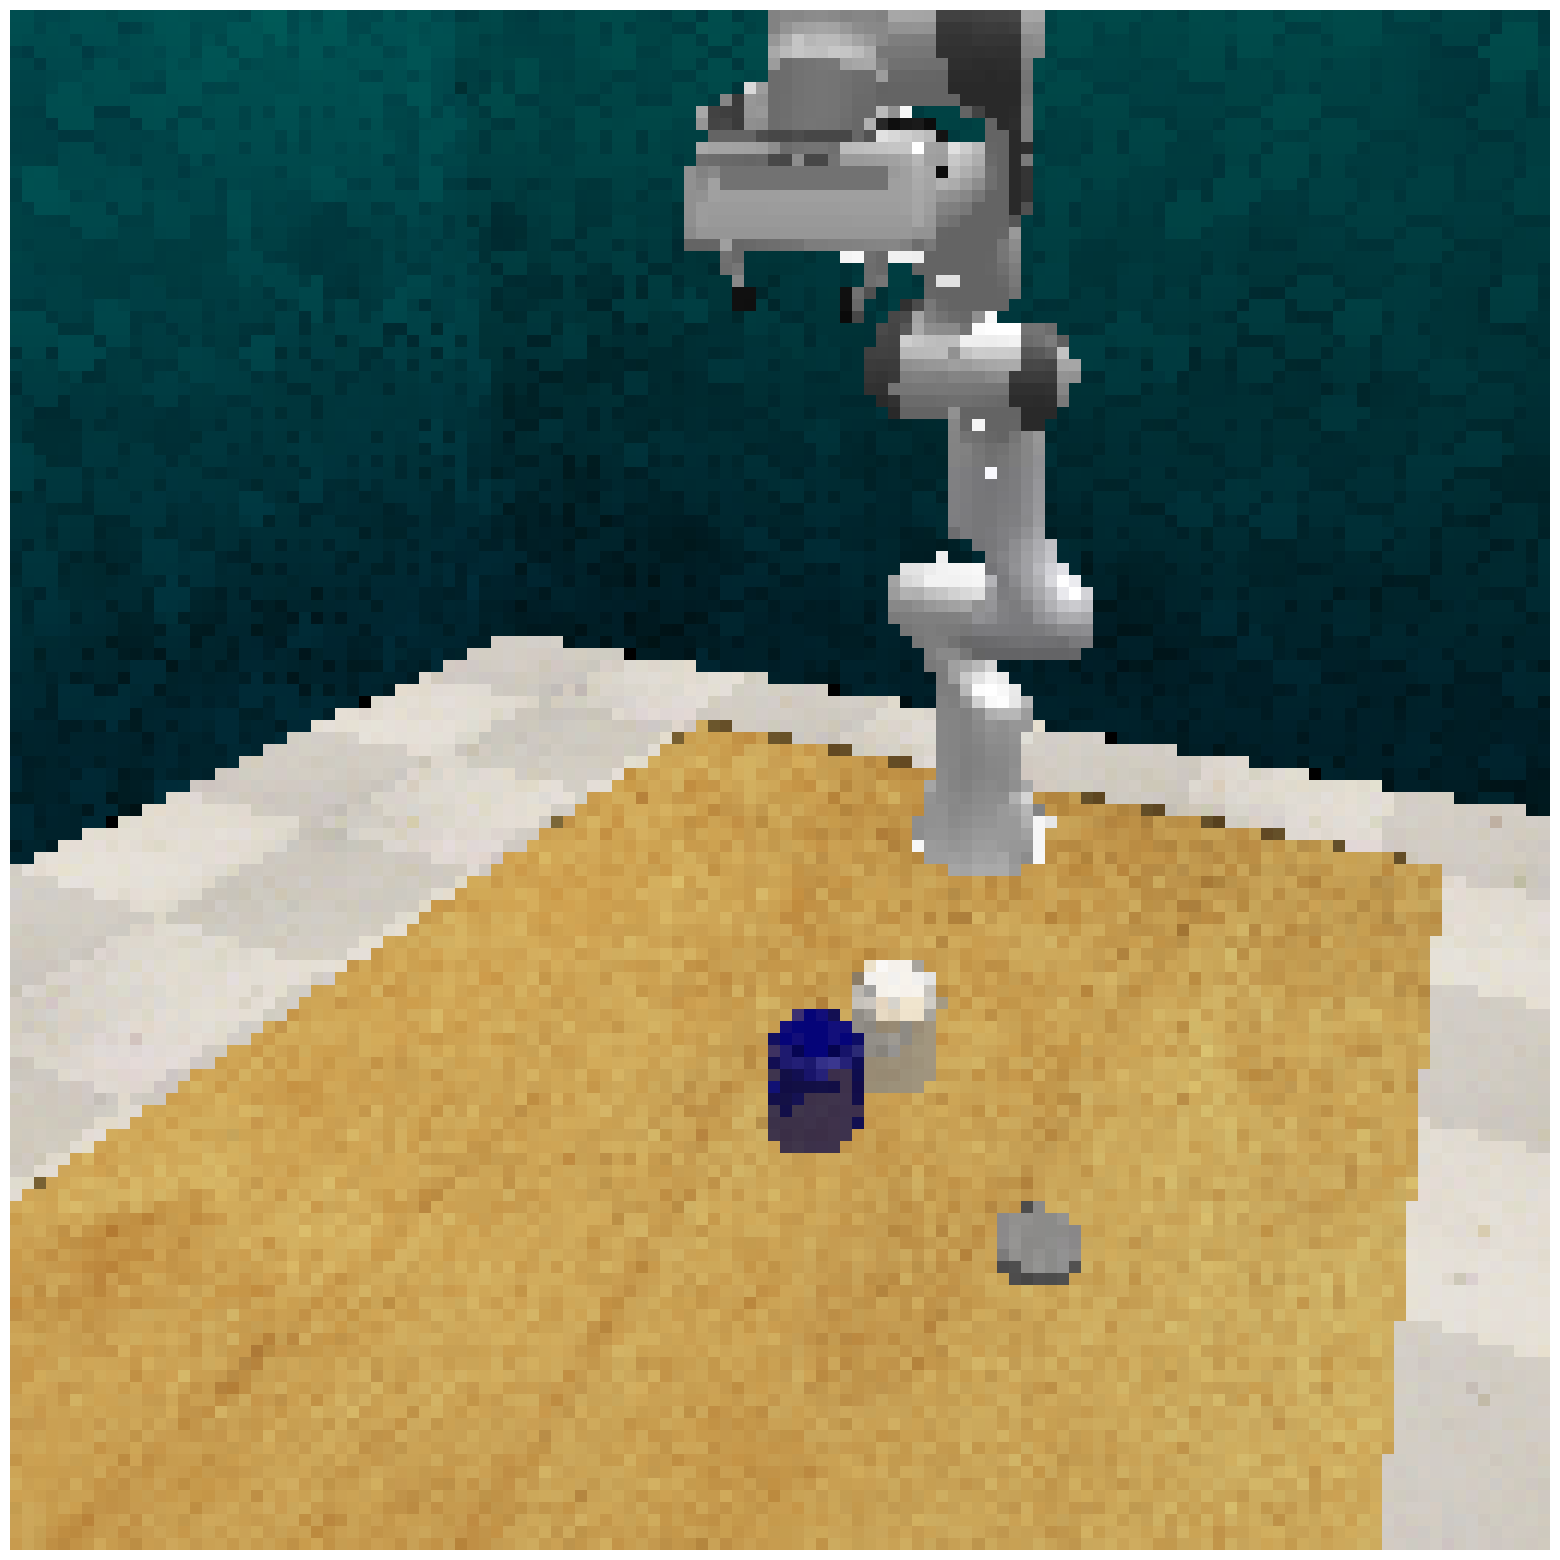

In [15]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [16]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# mask_generator = SAM2AutomaticMaskGenerator(
#     model=sam2)

mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.65,
    stability_score_thresh=0.9,
    stability_score_offset=1,
    crop_n_layers=0,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=50,
    use_m2m=False,
)

In [17]:
import cv2
def enhance_contrast(image):
    """
    直方图均衡化增强对比度 这个是因为发现SAM2有时候识别不出白色的物体 所以要增强对比度
    """
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)  # 转换到 LAB 颜色空间
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)  # 直方图均衡化增强亮度通道
    enhanced_lab = cv2.merge((l, a, b))
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    return enhanced_image

In [18]:
#masks = mask_generator.generate(image)
masks = mask_generator.generate(enhance_contrast(image))

In [19]:
print(len(masks))
print(masks[0].keys())

28
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


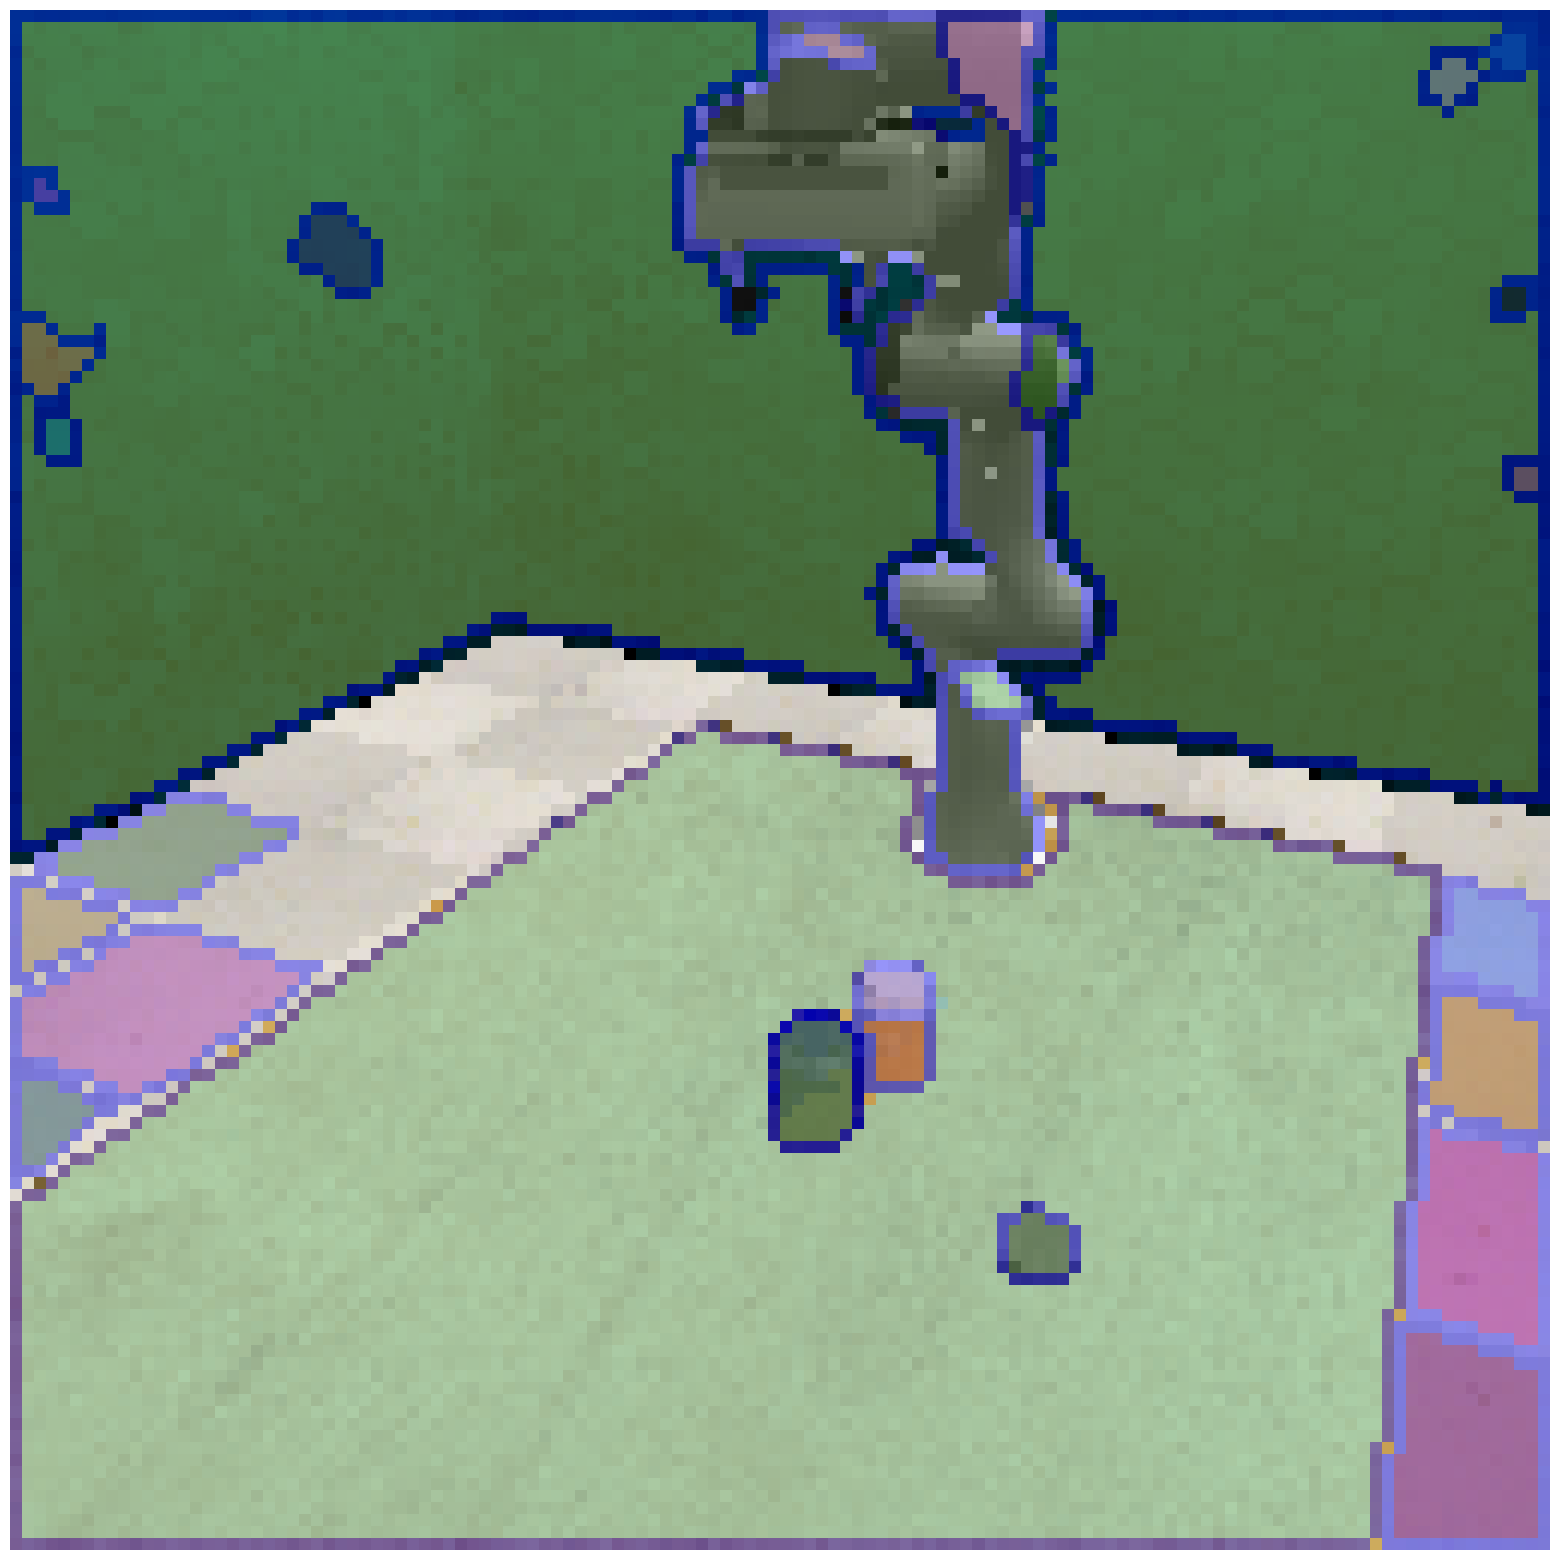

In [20]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 